# В этом ноутбуке мы обучим модель.

In [13]:
# Main imports
import os
import numpy as np
import pandas as pd

# Label encoder
import pickle
from sklearn.preprocessing import LabelEncoder

# Torch
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from sklearn.metrics import f1_score

# Images and graphics
from matplotlib import colors, pyplot as plt
%matplotlib inline

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path


In [14]:
DATA_MODES = ['train', 'val', 'test']

RESCALE_SIZE = 256

DEVICE = torch.device("cuda")

TEST_DIR = 'dataset/test'
TRAIN_DIR = 'dataset/data'

# 1. Подготовка.

## Класс датасета

In [15]:
class AvitoDataset(Dataset):
    def __init__(self, df: pd.DataFrame, mode):
        super().__init__()

        self.files = df['id']
        self.mode = mode
        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError
        
        
        self.labels = df['target']
        self.len = len(self.labels)

        self.label_encoder = LabelEncoder()

        if self.mode == 'train':
            # Обучаем Label Encoder
            self.label_encoder.fit(self.labels)

            # Сохраняем обученый енкодер
            with open('label_encoder.pkl', 'wb') as le_dump_file:
                pickle.dump(self.label_encoder, le_dump_file)

            # Запомним количество классов на будущее
            self.class_counts = self.labels.value_counts().sort_index()
        else:
            # Загружаем обученный Label Encoder
            if os.path.exists('label_encoder.pkl'):
                with open('label_encoder.pkl', 'rb') as le_dump_file:
                    self.label_encoder = pickle.load(le_dump_file)
            else:
                print('Label encoder file does not exist. Create train dataset first, to train label encoder.')
                raise FileNotFoundError
    
    def get_class_weights(self, min_size):
        """Возвращает веса для каждого класса"""
        if self.mode != 'train':
            raise ValueError("Weighted sampling только для train!")
        
        class_weights = 1. / torch.tensor(self.class_counts.values, dtype=torch.float)
        max_weight = 1 / min_size

        class_weights = torch.clamp(class_weights, max=max_weight)

        return class_weights
    
    def get_sample_weights(self, min_size):
        """Для каждого элемента в датасете возвратит его вес"""

        class_weights = self.get_class_weights(min_size)

        sample_weights = [class_weights[self.label_encoder.transform([label])[0]] 
                        for label in self.labels]
        
        return sample_weights
    
    def load_sample(self, file_id):
        # Путь до файла
        file_dir = TEST_DIR if self.mode == 'test' else TRAIN_DIR
        file = f'{file_dir}/{file_id}.jpg'

        image = Image.open(file)
        image.load()
        return image
    
    def __len__(self):
        return self.len
    
    def __getitem__(self, index):
        x = self.load_sample(self.files[index])

        if self.mode == 'train':
            # Определяем класс изображения
            label = self.labels[index]
            class_count = self.class_counts[label]

            # Базовые аугментации для всех классов
            transform_list = [
                transforms.RandomResizedCrop(RESCALE_SIZE, scale=(0.8, 1.0)),
            ]
             # Теперь определяем, насколько редкий класс
            if class_count < 50: # для редких классов
                transform_list.extend([
                    transforms.RandomAffine(degrees=25, translate=(0.2, 0.2)),
                    transforms.RandomPerspective(distortion_scale=0.5, p=0.7),
                    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
                    transforms.RandomHorizontalFlip(p=0.8),
                ])

            elif 50 <= class_count < 500: # Для менее редких классов
                transform_list.extend([
                transforms.RandomHorizontalFlip(0.5),
                transforms.RandomRotation(15),
                transforms.ColorJitter(brightness=0.2, contrast=0.2),
                ])
            else: # Для наиболее значимых классов
                transform_list.extend([
                transforms.RandomHorizontalFlip(p=0.3),
                ])

            transform_list.extend([
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])

            transform = transforms.Compose(transform_list)

            # Применяем наши преобразования
            x = transform(x)

        else:
            # Определяем стандартные преобразования
            basic_transform = transforms.Compose([
                transforms.Resize((RESCALE_SIZE, RESCALE_SIZE)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
            x = basic_transform(x)

        
        
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

## Объединение category + target

In [16]:
train_val_files = pd.read_csv('dataset/data.csv')

# Замена русских на англ
train_val_files = train_val_files.replace({'сумки': 'bags', 'одежда для девочек': "girls_wear", 'столы': "tabels", 'стулья': 'chairs'})

# Создание столбца таргетов
train_val_files['target'] = train_val_files['category'] + "_" + train_val_files['target']
train_val_files.drop(['category'], axis=1)

,id,target
0,11624739720,bags_zelenyi
1,11967354953,bags_chernyi
2,19026830493,bags_belyi
3,23088722867,bags_chernyi
4,23546690270,tabels_belyi
...,...,...
28298,37599243150,bags_bezhevyi
28299,37599243178,girls_wear_raznocvetnyi
28300,37599258032,bags_bezhevyi
28301,37599262080,girls_wear_bezhevyi


In [17]:
n_classes = len(train_val_files['target'].unique())

## Создадим новые датасеты.

In [18]:
train_val_labels = train_val_files['target']

# Делим выборку на train и val
from sklearn.model_selection import train_test_split
train_files, val_files = train_test_split(train_val_files, test_size=0.25, stratify=train_val_labels)

train_files = train_files.reset_index(drop=True)
val_files = val_files.reset_index(drop=True)

# Создадим объекты датасетов.
train_dataset = AvitoDataset(train_files, mode='train')
val_dataset = AvitoDataset(val_files, mode='val')

# Сравним размеры чтобы избежать ошибок.
print(f"Original len: train = {len(train_files)}, val = {len(val_files)}")
print(f"Dataset len: train = {train_dataset.len}, val = {val_dataset.len}")

Original len: train = 21227, val = 7076
Dataset len: train = 21227, val = 7076


## Сделаем weight sampleing

In [19]:
# Сделаем weight sampleing
from torch.utils.data import WeightedRandomSampler

MIN_SIZE = 150 # минимальный размер примера

# Получаем веса для каждого примера
sample_weights = train_dataset.get_sample_weights(MIN_SIZE)

# Получаем веса классов
class_weights = train_dataset.get_class_weights(MIN_SIZE)

# Создаём семплер
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),  # Сколько примеров выбирать за эпоху
    replacement=True  # Обязательно для миноритарных классов!
)

## Создадим Dataloaders

In [20]:
train_loader = DataLoader(train_dataset, batch_size=64, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

## Посмотрим на распределение классов.

<Axes: xlabel='target'>

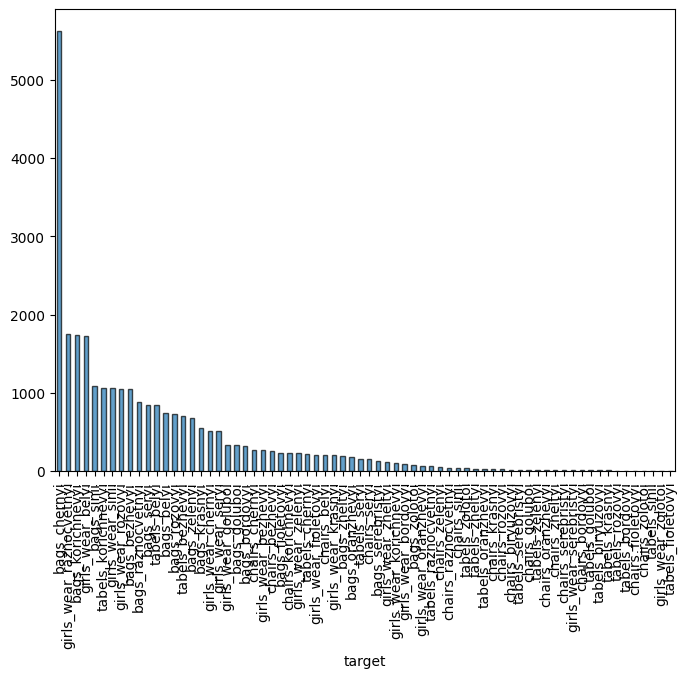

In [21]:
plt.figure(figsize=(8, 6))
train_val_files['target'].value_counts().plot(kind='bar', edgecolor='black', alpha=0.7)

In [22]:
# # Получаем список label_ids, которые будут сэмплиться
# sampled_label_ids = [train_dataset[index][1] for index in sampler]

# # Преобразуем в имена классов
# sampled_labels = train_dataset.label_encoder.inverse_transform(sampled_label_ids)

# # Рисуем гистограмму
# plt.figure(figsize=(12, 4))
# plt.hist(sampled_labels, bins=len(train_dataset.class_counts), edgecolor='black')
# plt.xticks(rotation=90)
# plt.title("Sampled Class Distribution (after WeightedRandomSampler)")
# plt.tight_layout()
# plt.show()

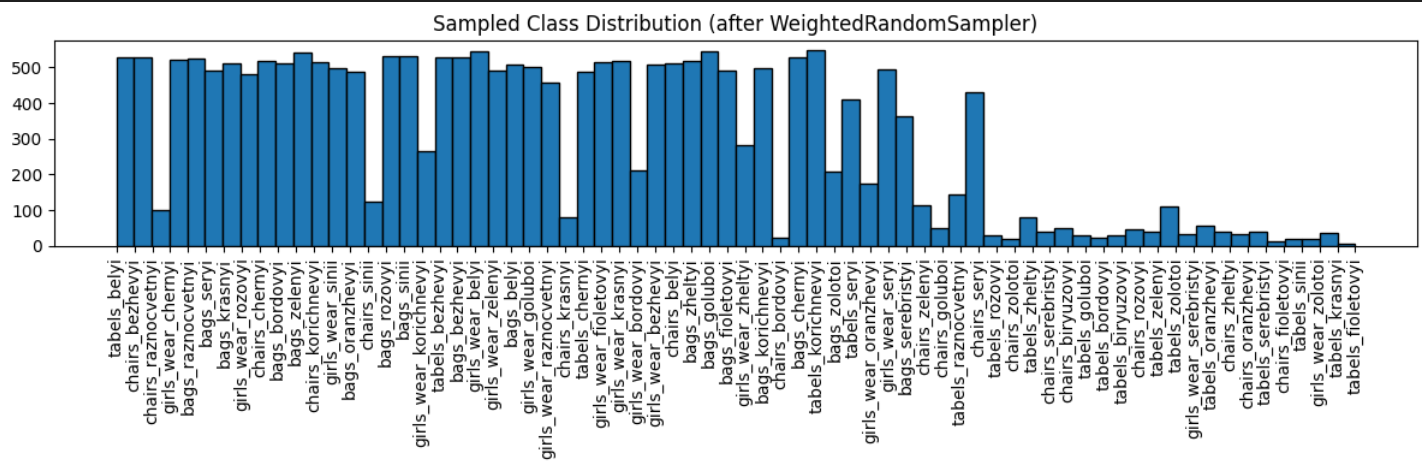

# Обучение модели.

Загрузим методы для обучения.

In [23]:
from scripts import train_utils

## Загрузим модель Res Net 34

In [24]:
import app.models.resnet_arch as my_models

model = my_models.get_model(n_classes)

c:\Users\vds\Work\Programming Stuff\hack\avito2\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\vds\Work\Programming Stuff\hack\avito2\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Разморозим fc слой и предпоследний свёрточный слой. Обучим модель на 10 эпох.

In [25]:
for param in model.parameters():
    param.requires_grad = False

model.layer4.requires_grad_(True)
model.fc.requires_grad_(True)

fc_layers(
  (fc): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
  )
  (out): Linear(in_features=256, out_features=70, bias=True)
)

In [26]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

In [28]:
history, last_model = train_utils.train(train_loader, val_loader, model, optimizer, criterion, epochs=10, model_name="resnet34ft")

Epochs:   0%|          | 0/10 [00:10<?, ?it/s]


KeyboardInterrupt: 